# TEST CASE FOR TELEMETRY FLOW ISSUE AT M2
The intention of this notebook is to show the irregular telemetry flow for the M2 that could affect the data analysis of the verification tests.

The efd fields `lsst.sal.MTM2.forceErrorTangent` and `lsst.sal.MTM2.tangentForce` will be used as case study. The aim is to demostrate that the former is a calculation of the latter using the function `_calculate_force_error_tangent()` of the `MockModel` class within the `lsst.ts.m2com.mock` util library.

During the experiment it will become clear the inconsistency between the two fields, due to the telemetry issue.

## IMPORT MODULES

In [1]:
import lsst_efd_client
from astropy.time import Time
from pandas import Timedelta
import numpy as np
import matplotlib.pyplot as plt
from lsst.ts.m2com.mock import MockModel
import pandas

Let's retrieve the two fields with two different query to the efd client.

In [2]:
efd_client = lsst_efd_client.EfdClient(efd_name="usdf_efd")
start_time = Time("2023-11-16T15:33:00.000", format="isot")
end_time = Time("2023-11-16T15:36:00.000", format="isot")

In [3]:
topic = "lsst.sal.MTM2.forceErrorTangent"
topic_fields = await efd_client.get_fields(topic)
query = efd_client.build_time_range_query(
            topic, topic_fields, start_time, end_time
        )
tangent_ferror_from_efd = await efd_client.influx_client.query(query)

In [4]:
topic = "lsst.sal.MTM2.tangentForce"
topic_fields = await efd_client.get_fields(topic)
query = efd_client.build_time_range_query(
            topic, topic_fields, start_time, end_time
        )
tangent_force = await efd_client.influx_client.query(query)

At this point we can inspect the length of the two dataframe.

If the Tangent Force error is a calculation from the Measured Tangent Force, the two dataframe should have the same length.

In [12]:
print(f'Tangent Force Error DataFrame: \nnrow = {tangent_ferror_from_efd.shape[0]} '
     f'ncol = {tangent_ferror_from_efd.shape[1]}')
print(f'Measured Tangent Force DataFrame: \nnrow = {tangent_force.shape[0]} ' 
      f'ncol = {tangent_force.shape[1]}')

Tangent Force Error DataFrame: 
nrow = 1783 ncol = 16
Measured Tangent Force DataFrame: 
nrow = 16 ncol = 38


So already at this stage the two telemtry are not consistent. But let's check if the Tangent Force error is calculated from the Tangent force for real.

Let's define a function that use the [MockModel()._calculate_force_error_tangent()](https://github.com/lsst-ts/ts_m2com/blob/develop/python/lsst/ts/m2com/mock/mock_model.py#L645-L710) function to calculate the Tangent Force Error from the Measured Tangent Force

In [18]:
def get_force_error_df(data: pandas.DataFrame) -> pandas.DataFrame:

    
    cols = ['force0', 'force1', 'force2', 'force3', 'force4','force5', 'sum', 'weight']
    df = pandas.DataFrame(columns=cols)
    for row in data.iterrows():
        tangent_force_error = MockModel()._calculate_force_error_tangent(np.array([row[1]['measured0'],
                                                                         row[1]['measured1'],
                                                                         row[1]['measured2'],
                                                                         row[1]['measured3'],
                                                                         row[1]['measured4'],
                                                                         row[1]['measured5']
                                                                         ]))
        
        df.loc[row[0], cols[:-2]] = tangent_force_error['force']
        df.loc[row[0], cols[-2]] = tangent_force_error['weight']
        df.loc[row[0], cols[-1]] = tangent_force_error['sum']

    return df

We can use this function to create a new Tangent Force Error dataframe, calculated form scratch.

In [20]:
calculate_tangent_ferror = get_force_error_df(tangent_force)
calculate_tangent_ferror.head()

,force0,force1,force2,force3,force4,force5,sum,weight
2023-11-16 15:33:07.258156+00:00,47.99,-122.187524,-14.878316,-6.36,49.285506,35.905413,222.25676,-18.27
2023-11-16 15:33:08.500423+00:00,48.9,-122.37805,-15.294009,-6.31,49.138281,35.853452,222.663792,-18.24
2023-11-16 15:33:29.426814+00:00,48.37,-122.37805,-14.878316,-7.34,50.255454,35.992016,223.503836,-17.87
2023-11-16 15:33:29.530469+00:00,47.99,-123.166133,-15.718361,-7.66,49.839762,36.321105,225.045361,-20.55
2023-11-16 15:33:33.404938+00:00,47.72,-123.261396,-15.250707,-3.24,49.605935,35.714888,223.832926,-16.94


Now match the calculated Tangent Force Error with the one retrieve from efd.
We will use just one Tangent Force Error to mantain this notebook lightweight.

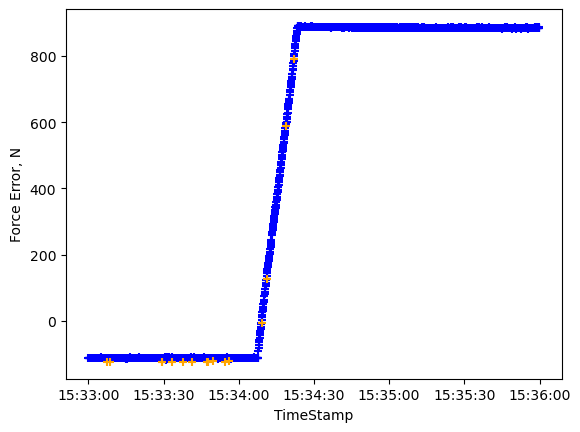

In [23]:
plt.scatter(tangent_ferror_from_efd.index, tangent_ferror_from_efd.force1,
           marker='+', c='blue', label='From EFD')
plt.scatter(calculate_tangent_ferror.index, calculate_tangent_ferror.force1,
           marker='+', c='orange', label='Calculated')
plt.xlabel('TimeStamp')
plt.ylabel('Force Error, N')
plt.legend()
plt.show()

Let's match the two dataframe in order to compare only the data caluclate and the correspetive one taken from the EFD.

It is possible do this using the [`lsst_efd_client.rendezvous_dataframes()`](https://efd-client.lsst.io/api/lsst_efd_client.rendezvous_dataframes.html), that match two dataframes using the TimeIndex fo them.

In [38]:
tol = Timedelta(seconds=1.0)
match_df = lsst_efd_client.rendezvous_dataframes(
    calculate_tangent_ferror, tangent_ferror_from_efd,
    direction="nearest", tolerance=tol,
    suffixes=[f"_{'TangentFerrorCalc'}", f"_{'TangentFerrorEfd'}"])

In [41]:
match_df.head()

,force0_TangentFerrorCalc,force1_TangentFerrorCalc,force2_TangentFerrorCalc,force3_TangentFerrorCalc,force4_TangentFerrorCalc,force5_TangentFerrorCalc,sum_TangentFerrorCalc,weight_TangentFerrorCalc,force0_TangentFerrorEfd,force1_TangentFerrorEfd,...,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,sum_TangentFerrorEfd,weight_TangentFerrorEfd
2023-11-16 15:33:07.258156+00:00,47.99,-122.187524,-14.878316,-6.36,49.285506,35.905413,222.25676,-18.27,47.99,-111.16,...,1.700149e+09,MTM2,1.700149e+09,52859,1.700149e+09,b9e7700c,1506349,1.700149e+09,-18.28,178.12
2023-11-16 15:33:08.500423+00:00,48.9,-122.37805,-15.294009,-6.31,49.138281,35.853452,222.663792,-18.24,48.90,-111.21,...,1.700149e+09,MTM2,1.700149e+09,52859,1.700149e+09,b9e7700c,1506361,1.700149e+09,-18.23,178.01
2023-11-16 15:33:29.426814+00:00,48.37,-122.37805,-14.878316,-7.34,50.255454,35.992016,223.503836,-17.87,48.37,-111.14,...,1.700149e+09,MTM2,1.700149e+09,52859,1.700149e+09,b9e7700c,1506568,1.700149e+09,-17.86,178.58
2023-11-16 15:33:29.530469+00:00,47.99,-123.166133,-15.718361,-7.66,49.839762,36.321105,225.045361,-20.55,47.99,-111.80,...,1.700149e+09,MTM2,1.700149e+09,52859,1.700149e+09,b9e7700c,1506569,1.700149e+09,-20.55,179.60
2023-11-16 15:33:33.404938+00:00,47.72,-123.261396,-15.250707,-3.24,49.605935,35.714888,223.832926,-16.94,47.72,-111.83,...,1.700149e+09,MTM2,1.700149e+09,52859,1.700149e+09,b9e7700c,1506607,1.700149e+09,-16.93,178.12


Now we can plot toghether the retrieved Tangent Force Error and the calculated one.

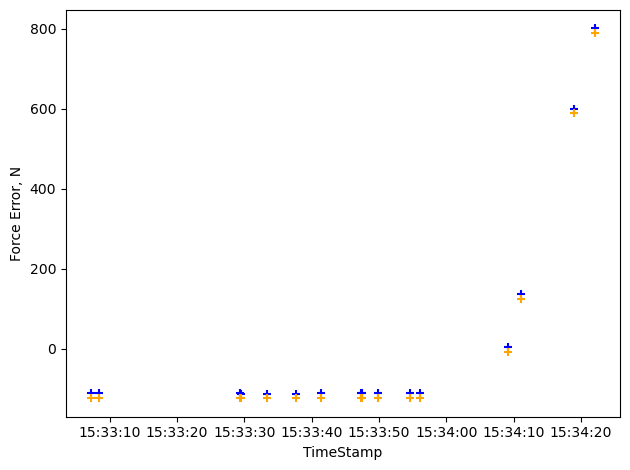

In [42]:
plt.scatter(match_df.index, match_df.force1_TangentFerrorEfd,
           marker='+', c='blue', label='From EFD')
plt.scatter(match_df.index, match_df.force1_TangentFerrorCalc,
           marker='+', c='orange', label='Calculated')
plt.xlabel('TimeStamp')
plt.ylabel('Force Error, N')
plt.legend()
plt.tight_layout()
plt.show()

Even though with some offset the two dataset is consistent.
With this evidence we are quite confident that the Tangent Measured Force is the source for the calculation that return the Tangent Force Error.

But where are gone all the rest of the Tangent Measured Force telemetry data?

The scenarios that could explain the inconsistency could be the following:
1. The Tangent Force Error telemetry flow the last calculation value until a new one is obtain.
2. Many samples of the Tangent Measured Force are missed after the caluclation and they are not published.

It is possible to check the first scenario veri easly, controlling how many unique value are present in the Tangent Force Error telemtry retrive from the EFD. If the case 1 is right, the number of unique values in this field should be the same number of the Tangent Measrued Force samples.

In [47]:
tangent_ferror_from_efd.force1.drop_duplicates()

2023-11-16 15:33:00.015621+00:00   -111.04
2023-11-16 15:33:00.118619+00:00   -111.07
2023-11-16 15:33:00.222352+00:00   -111.05
2023-11-16 15:33:00.325375+00:00   -111.75
2023-11-16 15:33:00.428896+00:00   -110.82
                                     ...  
2023-11-16 15:35:58.155694+00:00    885.72
2023-11-16 15:35:58.361482+00:00    886.45
2023-11-16 15:35:59.292586+00:00    884.29
2023-11-16 15:35:59.810988+00:00    886.49
2023-11-16 15:35:59.914902+00:00    883.48
Name: force1, Length: 809, dtype: float64

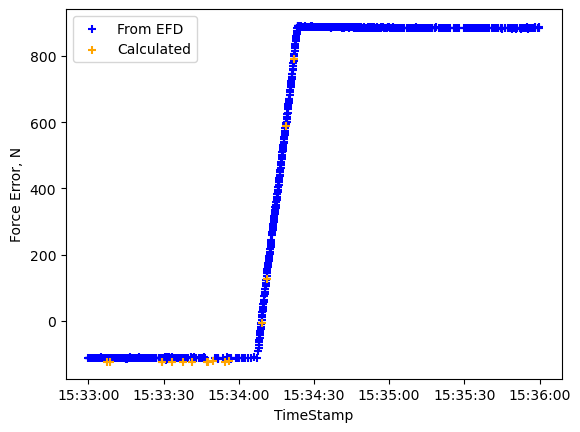

In [48]:
plt.scatter(tangent_ferror_from_efd.force1.drop_duplicates().index,
            tangent_ferror_from_efd.force1.drop_duplicates(),
           marker='+', c='blue', label='From EFD')
plt.scatter(calculate_tangent_ferror.index, calculate_tangent_ferror.force1,
           marker='+', c='orange', label='Calculated')
plt.xlabel('TimeStamp')
plt.ylabel('Force Error, N')
plt.legend()
plt.show()

With this analysis we can conclude that the scenario number 1 proposed above is not confirmed and maybe the number 2 could lies on the right way to fix this incosistency in the telemetry published in the EFD.